### Software Research Institute Placement
### Summer 2021

#### Building an app to predict crowdedness levels at the college gym.


### Data Overview

Get an overview of the data.


In [1]:
#import required libraries
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from subprocess import check_output
from datetime import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read in the file & check there is no missing data.

In [2]:
gym_data = pd.read_csv('GymData.csv')
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


This is a valid dataset with 62184 entries, with 11 columns & no missing data. 

Next print out the first 5 rows, to see an example of the data.

In [3]:
gym_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


This dataframe contains 11 columns of information.
* number_people: the number of people present in the gym.
* date: the date (year-month-day) & time (24 hour format), in 10 minute intervals.
* timestamp: time of day, converted into seconds, e.g. 10:00 equals 36,000. 
* day_of_week: integer values from 0 to 6, representing the days Monday to Sunday, 0 equals Monday etc.
* is_weekend: values 0 or 1, 0 value if Monday to Friday, 1 if Saturday or Sunday.
* is_holiday: values 0 or 1, 0 value for non-holiday days, 1 for holiday days.
* temperature: the local outside temperature, at each timepoint, measured in Farenheit.
* is_start_of_semester: 14 day time period at the start of each of two semesters each year (1st semester end Aug & start of Sept & 2nd semester in January, e.g. 26th August - 8th September 2015.
* is_during_semester: values 0 or 1, 0 value for non-semester days, 1 for semester days.
* month: integer values from 1 to 12, representing the months January to December, 1 equals January etc.
* hour: integer values from 0 to 23, representing the hours of the day, in 24hr format.

Next print some descriptive statistics, to ensure the data is logical.

In [4]:
gym_data.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


The dataset is logical as:

* Number of rows for all the data columns are same, each containing 62184 values.
* Maximum number of people = 145 and min = 0, which makes logical sense.
* The values for timestamp should be between 0 and 86,400, max = 86120 and min = 0,so all values are acceptable. 
* There should be 7 values for day of the week, max = 6 and min = 0, so all values are acceptable.
* is_weekend, is_holiday, is_start_of_semester, is_during_semester should all contain either 0 or 1 values. All meet this criteria.
* Temperature range is logical, max = 87 and min = 38.
* There should be 12 values for month, max = 12 and min = 1, so all values are acceptable.
* There should be 24 values for hour, max = 23 and min = 0, so all values are acceptable.


### Feature Engineering

Check if any of the data needs to be manipulated.


Convert temperature & day of the week data, to make it easier to interpret.
Check that changes have been made.

In [5]:
#convert temperature column from Farenheit to Celcius
gym_data.temperature = gym_data.temperature.apply(lambda x: int((x-32)*(5/9)))
gym_data.rename(columns={"temperature":"temperature_celsius"}, inplace = True)

In [6]:
#Change day of week to 1-7 instead of 0-6 for readability, 1 = Monday, 7 = Sunday
gym_data.day_of_week = gym_data.day_of_week.apply(lambda x: x+1)

In [7]:
#Check that changes have taken place to day of the week
gym_data.day_of_week.describe()

count    62184.000000
mean         3.982504
std          1.996825
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max          7.000000
Name: day_of_week, dtype: float64

In [8]:
#Check that changes have taken place to temperature
gym_data.temperature_celsius.describe()

count    62184.000000
mean        14.258491
std          3.517804
min          3.000000
25%         12.000000
50%         14.000000
75%         16.000000
max         30.000000
Name: temperature_celsius, dtype: float64

Print a visual overview of the complete data, using Pair Plots in Seabourn. 
Pairplot shows histograms of the columns in the diagonal of the matrix and pairwise scatter plot of the data.
This may help to identify features that can be removed.

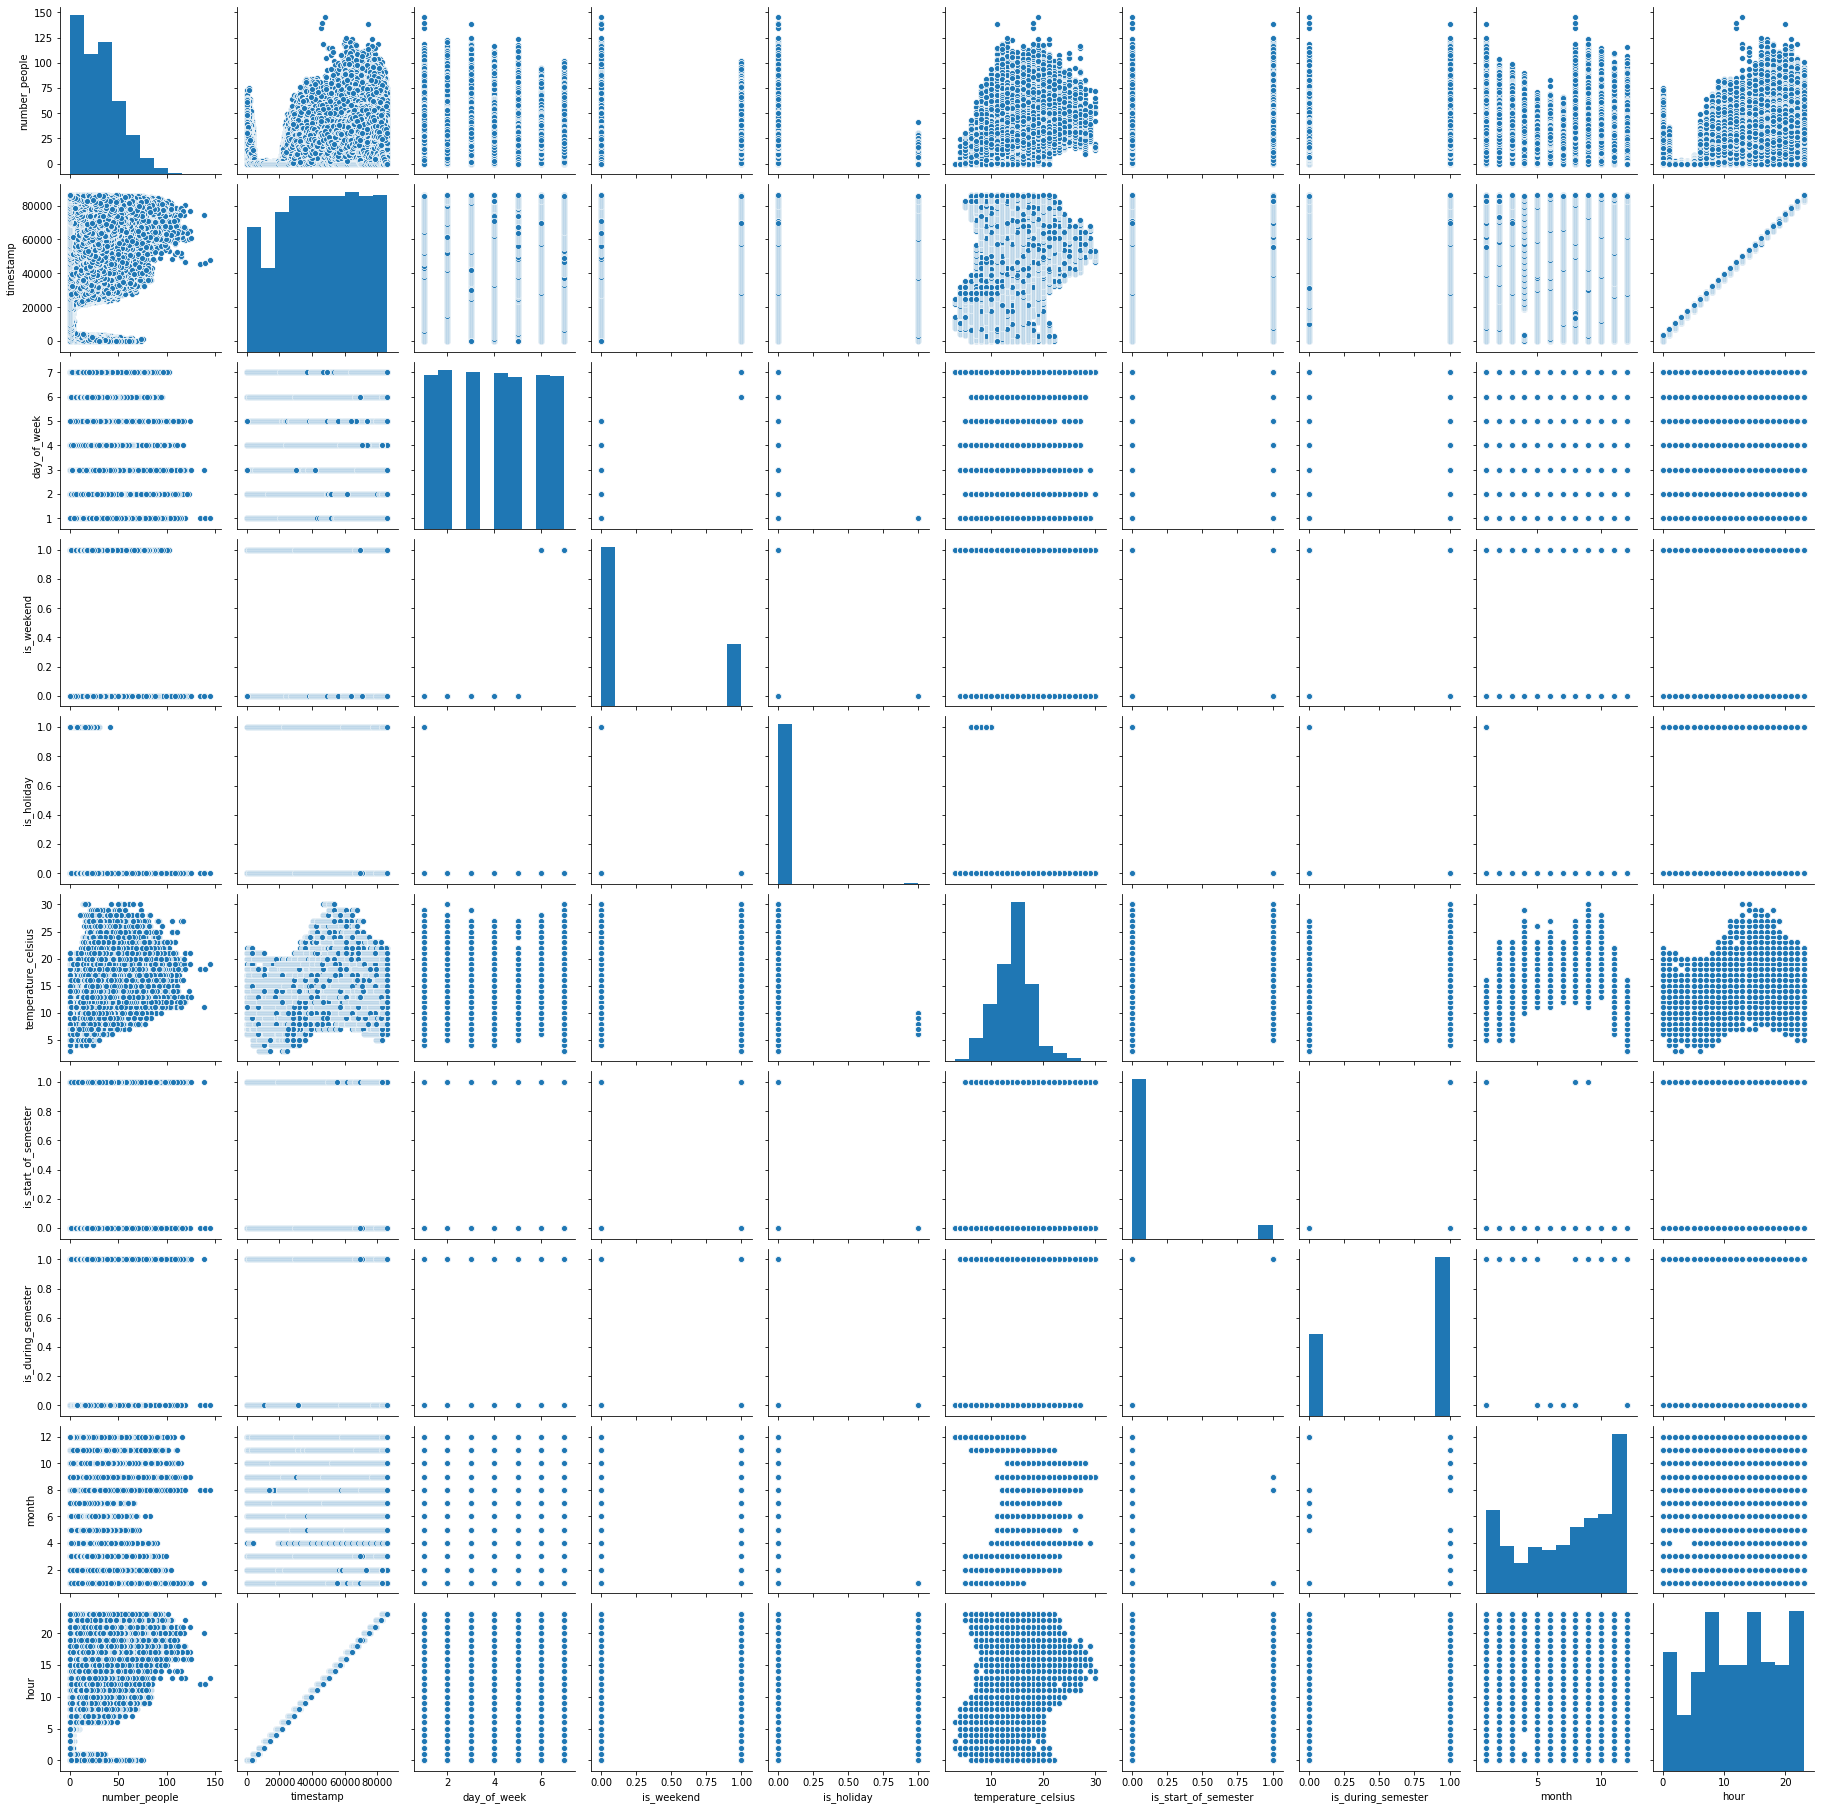

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(gym_data)


Looking at the diagonal histograms in the Pair Plots above, shows that there is little positive data for the 'is_holiday' variable.

Looking into this further, to see the number of entries for is_holiday column that have a '1' value.

In [10]:
gym_data.groupby(by='is_holiday').count()

,number_people,date,timestamp,day_of_week,is_weekend,temperature_celsius,is_start_of_semester,is_during_semester,month,hour
is_holiday,,,,,,,,,,
0,62024,62024,62024,62024,62024,62024,62024,62024,62024,62024
1,160,160,160,160,160,160,160,160,160,160


This shows that there are only 160 positive entries for the 'is_holiday' column, corresponding to only 2 days in 2017. Logically this doesn't make sense, as there would be expected to be holiday days every year. Therefore as the data for this feature is likely not complete or accurate, it will be removed at this stage.


In [11]:
del gym_data['is_holiday']

Looking at the Pair Plots above, shows that there is a strong correlation between the timestamp & the hour column.

Print a heatmap of the correlations to get a better look at this.

Text(0.5, 1, 'Correlation between different fearures')

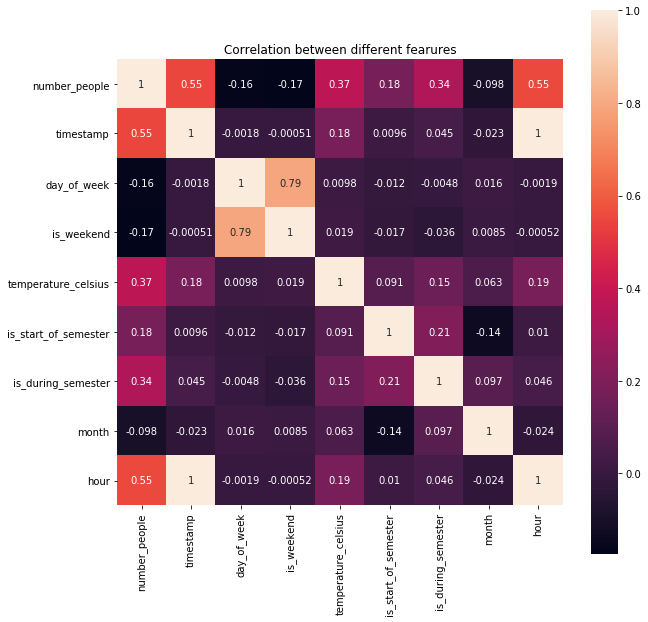

In [12]:
#show the correlation between features
correlation = gym_data.corr()
#create and display a graph figure
plt.figure(figsize=(10,10))
#use the heatmap from sns libray and choose the options(color, shape)
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='rocket')
#Display the title of the graph
plt.title('Correlation between different fearures')

From the heatmap above, the 3 factors with the highest correlation with number of people attending the gym are:
* time/hour
* is_during_semester
* temperature

We can also observe that timestamp and hour have a correlation value of 1, which logically would be expected.
As the timestamp is not giving us any additional information that is not contained eleswhere in the dataset, we will delete the timestamp column.

In [13]:
del gym_data['timestamp']

It may be useful to add a column to the dataframe with day of the month details, which can be extracted from the date column.

In [14]:
#get characters between 8th and 11th place to extract just the day of the month, from the whole date
def get_date(series):
    return series.str.slice(8,11) 
#dataframe with only the day of the month from the date
gym_data['day_of_month'] = gym_data[['date']].apply(get_date) 

In [15]:
gym_data.head()

,number_people,date,day_of_week,is_weekend,temperature_celsius,is_start_of_semester,is_during_semester,month,hour,day_of_month
0,37,2015-08-14 17:00:11-07:00,5,0,22,0,0,8,17,14
1,45,2015-08-14 17:20:14-07:00,5,0,22,0,0,8,17,14
2,40,2015-08-14 17:30:15-07:00,5,0,22,0,0,8,17,14
3,44,2015-08-14 17:40:16-07:00,5,0,22,0,0,8,17,14
4,45,2015-08-14 17:50:17-07:00,5,0,22,0,0,8,17,14


The changes made from the original dataset include:
* deleting the 'timestamp' column
* changing the day of the week values from 0 to 6, to 1 to 7
* converting the temperature from farenheit to celsius
* deleting the 'is_holiday' column
* adding a 'day_of_month' column


### Data Analysis

Looking in more detail at the factors that showed highest correlation with gym attendance numbers:
* time/hour
* is_during_semester
* temperature.


#### Time

Construct heatmap of the hours of the day & days of the week, to get an overview of the data.

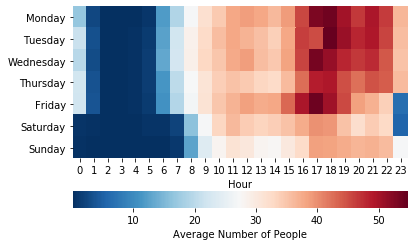

In [16]:
g = gym_data[['hour','number_people','day_of_week']] #dataframe with hour, number of people and the day of the week columns

F = g.groupby(['hour','day_of_week'], as_index = False).number_people.mean().pivot('day_of_week','hour','number_people').fillna(0) #resharp the dataframe with the mean of people number

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}

dow= 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split() #splitting the string


ax = sns.heatmap(F, cmap='RdBu_r',cbar_kws={"orientation": "horizontal"}) #cmap = Red/Blue, colorbar horizontal
ax.set_yticklabels(dow, rotation = 0) # axis labels
ax.set_ylabel('')
ax.set_xlabel('Hour')

cbar = ax.collections[0].colorbar
cbar.set_label('Average Number of People')

This heatmap corresponds with what one might expect for attendance levels at a college gym.
It shows that more people visit the gym in the late afternoon & evening, while it is quieter in the morning (when people are more likely to have classes).
It also shows that the gym is busier during the week, in comparision with the weekend, when people may not be on the college campus.

Looking specifically at days of the week, the graph below shows the total attendance numbers for each of the 7 days.

[288590, 296140, 291356, 269721, 261196, 202524, 198320]


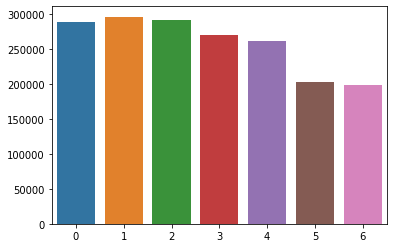

In [17]:
Bins = []
for i in range(1,8):
    NumberofPeople = 0
    for index, row in gym_data.iterrows():
        if(row['day_of_week'] >= i and row['day_of_week'] < i+1):
            NumberofPeople = NumberofPeople + row['number_people']
    Bins.append((NumberofPeople))
print(Bins)
            
                       
sns.barplot(list(range(7)),Bins)

As previously seen in the heatmap, the graph above also shows that gym attendance is higher from Monday to Friday, in comparison to Saturday & Sunday.

Looking specifically at hours of the day, the graph below shows the total attendance numbers for each of the 24 hour.

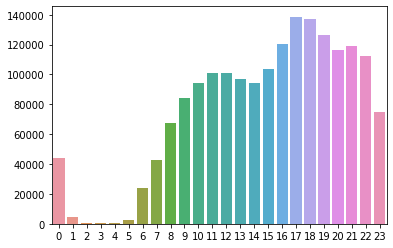

In [18]:
Bins = []
for i in range(0,24):
    NumberofPeople = 0
    for index, row in gym_data.iterrows():
        if(row['hour'] >= i and row['hour'] < i+1):
            NumberofPeople = NumberofPeople + row['number_people']
    Bins.append((NumberofPeople))
                  
sns.barplot(list(range(24)),Bins)

As previously seen in the heatmap, the graph above also shows that gym attendance is higher in the late afternoon & evening, lower in the morning time, and negligible during the night.

#### During semester

Construct heatmap of the days of the week & months of the year, to get an overview of the data.

Text(0.5, 42.0, 'Day of the Month')

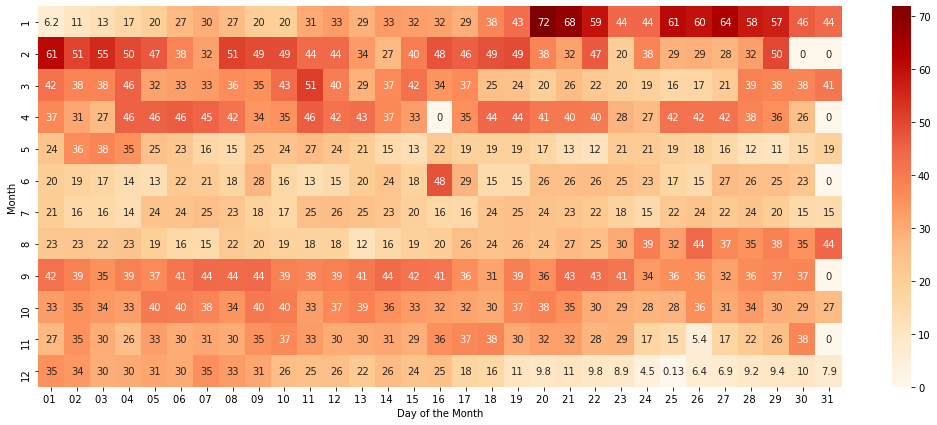

In [19]:
month_date_count_df = pd.pivot_table(gym_data, columns=['day_of_month'],index=['month'], values='number_people', aggfunc=np.mean) #reshape the dataframe
month_date_count_df.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(18,7)) 
heatmap = sns.heatmap(month_date_count_df, annot=True, ax=ax, cmap="OrRd") #heatmap with the reshaped dataframe, with colors from Orange to Red
heatmap.set_ylabel('Month')
heatmap.set_xlabel('Day of the Month')

This heatmap corresponds with what one might expect for attendance levels at a college gym.
It shows that more people visit the gym during semester time, while it is quieter in the summer months (when people may not be on the college campus).
It also shows that the gym is busiest in mid January to early February, which is comparable to most gyms, due to New Year's Resolutions.

Comparing the numbers attending during the semester with the numbers attending outside of the semester, should give a similar result to that seen in the heatmap.

In [20]:
NumberofPeopleDuringSem = 0
NumberofPeopleOutsideSem = 0
for index, row in gym_data.iterrows():
    if(row['is_during_semester'] == 1):
        NumberofPeopleDuringSem = NumberofPeopleDuringSem + row['number_people']
    else:
        NumberofPeopleOutsideSem = NumberofPeopleOutsideSem + row['number_people']
print('Number of people attending gym outside of sem = ' + str(NumberofPeopleOutsideSem))
print('Number of people attending gym during sem = ' + str(NumberofPeopleDuringSem))

Number of people attending gym outside of sem = 390178
Number of people attending gym during sem = 1417669


As expected, the total number of people attending the gym during the semester is much higher than the total number attending outside of term time.

#### Temperature

Construct heatmap of the hours of the day & days of the week, to get an overview of the data.

Text(0.5, 42.0, 'Temperature')

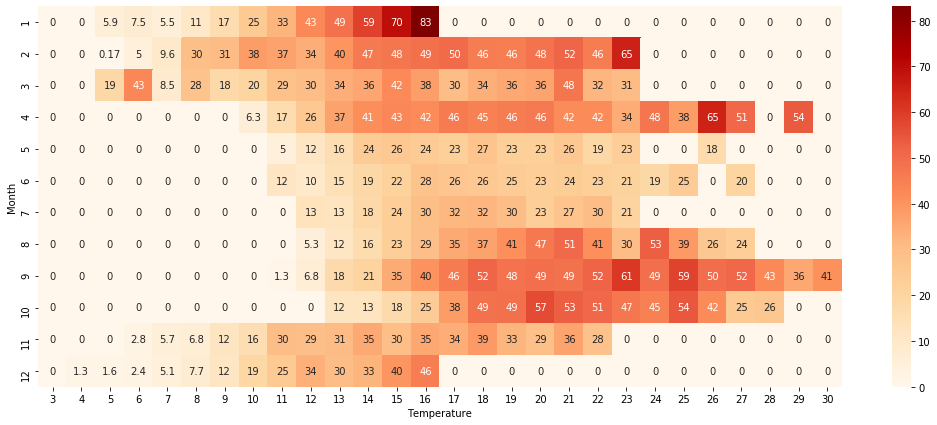

In [21]:
month_date_count_df = pd.pivot_table(gym_data, columns=['temperature_celsius'],index=['month'], values='number_people', aggfunc=np.mean) #reshape the dataframe
month_date_count_df.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(18,7)) 
heatmap = sns.heatmap(month_date_count_df, annot=True, ax=ax, cmap="OrRd") #heatmap with the reshaped dataframe, with colors from Orange to Red
heatmap.set_ylabel('Month')
heatmap.set_xlabel('Temperature')

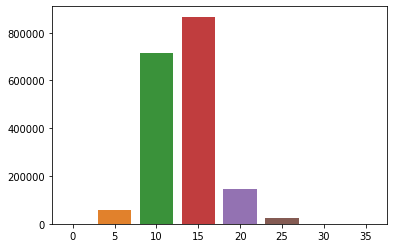

In [22]:
Bins = []
for i in range(0,40,5):
    NumberofPeople = 0
    for index, row in gym_data.iterrows():
        if(row['temperature_celsius'] >= i and row['temperature_celsius'] < i+5):
            NumberofPeople = NumberofPeople + row['number_people']
    Bins.append((NumberofPeople))
                  
sns.barplot(list(range(0,40,5)),Bins)

From the graph above it looks like most people attend the gym when it's between 10 & 20 degrees. 

The graph below shows the distribution of temperatures.

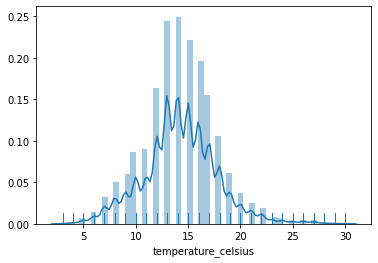

In [23]:
sns.distplot(gym_data['temperature_celsius'], kde=True, rug=True)

It shows that the majority of the time the temperature is between 10 & 20 degrees.
Therefore it makes sense that the majority of people attend the gym when it's between 10 & 20 degrees, as that temperture range occurs so frequently.
This suggests that although the temperature correlates with attendance, it may not be a causative factor attendance levels. 

### Machine Learning Models

#### Linear Regression

#### Random Forest

Encoding and Scale Data

In [24]:
# one hot encoding
df = gym_data.drop("date", axis=1)
columns = ["day_of_week", "month", "hour"]
df = pd.get_dummies(df, columns=columns)
df.head()

,number_people,date,day_of_week,is_weekend,temperature_celsius,is_start_of_semester,is_during_semester,month,hour,day_of_month
0,37,2015-08-14 17:00:11-07:00,5,0,22,0,0,8,17,14
1,45,2015-08-14 17:20:14-07:00,5,0,22,0,0,8,17,14
2,40,2015-08-14 17:30:15-07:00,5,0,22,0,0,8,17,14
3,44,2015-08-14 17:40:16-07:00,5,0,22,0,0,8,17,14
4,45,2015-08-14 17:50:17-07:00,5,0,22,0,0,8,17,14


Split dataframe to Train set and Test set

In [25]:
data = df.values
X = data[:, 1:]  # all rows, no label
y = data[:, 0]  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Implement scaler on temperature

In [26]:
scaler1 = StandardScaler()
scaler1.fit(X_train[:, 3:4])
X_train[:, 3:4] = scaler1.transform(X_train[:, 3:4])
X_test[:, 3:4] = scaler1.transform(X_test[:, 3:4])

In [27]:
print(X_train.shape)
print(y_train.shape)

(46638, 48)
(46638,)


Random Forest Regressor Model

In [28]:
model = RandomForestRegressor(n_jobs=-1)

score =  0.9244578409659866
score =  0.9247278499368485
score =  0.9249046734851216
score =  0.9251749776056102
score =  0.9250011171755061
score =  0.9250725084831073


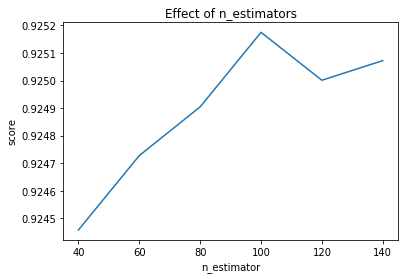

In [29]:
estimators = np.arange(40, 160, 20)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    print('score = ', model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

Evaluate Regression Model

In [30]:
import sklearn.metrics as metrics

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true + 1 - y_pred) / (y_true + 1)) * 100)
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('R^2: ', r2)
    print('MAE: ', mean_absolute_error)
    print('MSE: ', mse)
    print('RMSE: ', np.sqrt(mse))
    print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred), '%')

In [32]:
regression_results(y_test, model.predict(X_test))

explained_variance:  0.9251
mean_squared_log_error:  0.137
R^2:  0.9250725084831073
MAE:  4.214092365589681
MSE:  38.60959197391443
RMSE:  6.21366172026724
MAPE:  34.03331678250936 %


#### Neural Network

In [33]:
#import libraries
from keras.models import Sequential 
from keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [34]:
data = gym_data.values
X = data[:, 1:]  # all rows, no label
y = data[:, 0]  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
print(X_train.shape)
print(y_train.shape)

(46638, 9)
(46638,)


In [36]:
def create_network():
    model = Sequential()
    model.add(Dense(64, input_shape=(49,), activation='relu')) 
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy']) 
    return model

In [37]:
earlyStopping = EarlyStopping(patience=30, verbose=1)
mcp_save = ModelCheckpoint('gym_model.h5', verbose=0, save_best_only=True, save_weights_only=True)
reduce_lr_loss = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.000001, verbose=0)
callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [38]:
model = create_network()
results = model.fit(X_train, y_train, epochs = 500, batch_size = 64, 
                    validation_data = (X_test, y_test), verbose = 0)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
model.evaluate(X_test, y_test)